# skeletonization + resize + sending pixels to csv


In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import csv
from skimage import img_as_float
from skimage import io, color, morphology

In [3]:
# point to license plate image (works well with custom crop function)
img = cv2.imread("13.jpg",0)
cv2.imshow("input", img)
cv2.waitKey(0)

gray = cv2.resize(img, None, fx = 1, fy = 1, interpolation = cv2.INTER_CUBIC)
blur = cv2.GaussianBlur(img, (5,5), 0)
cv2.imshow("Guass_blur image", blur)
cv2.waitKey(0)
gray = cv2.medianBlur(img, 3)
# perform otsu thresh (using binary inverse since opencv contours work better with white text)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
cv2.imshow("Thresh image", thresh)
cv2.waitKey(0)


-1

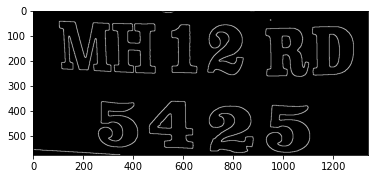

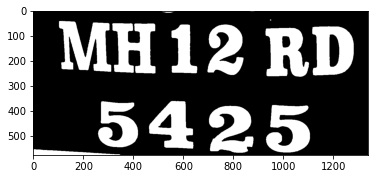

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
gradient=cv2.morphologyEx(thresh,cv2.MORPH_GRADIENT,kernel)
plt.imshow(gradient,cmap='gray')
plt.show()
# apply dilation 
dilation = cv2.dilate(thresh, kernel, iterations = 1)
plt.imshow(dilation,cmap='gray')
#cv2.imshow("dilation", dilation)
plt.show()
# find contours

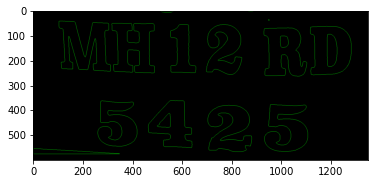

In [5]:
# find contours
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

#drawing these contours
blank = np.zeros((600, 1350, 3), dtype='uint8')
cv2.drawContours(blank, contours ,-1, (0,255,0), 1)

plt.imshow(blank,cmap='gray')
plt.show()
#cv2.imshow("contours drawn", blank)
#cv2.waitKey(0)
#cv2.destroyAllWindows()'''

# region interest and its skeleton

roi_size: (20, 20)


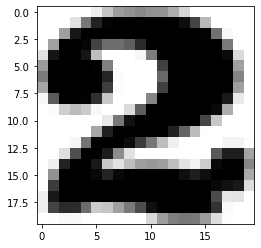

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379B856CD0>
skel_size: (35, 35)


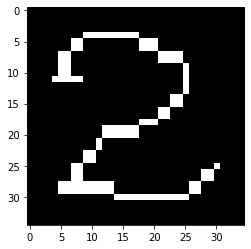

roi_size: (20, 20)


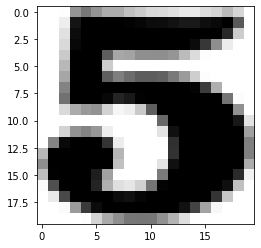

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D75B220>
skel_size: (35, 35)


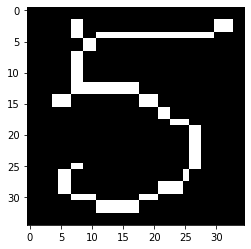

roi_size: (20, 20)


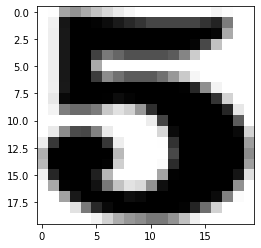

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D75B220>
skel_size: (35, 35)


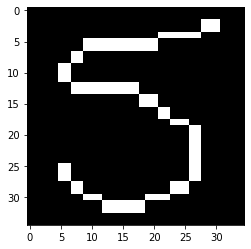

roi_size: (20, 20)


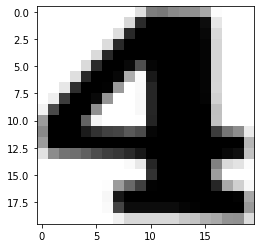

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D75B220>
skel_size: (35, 35)


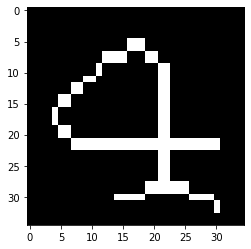

roi_size: (20, 20)


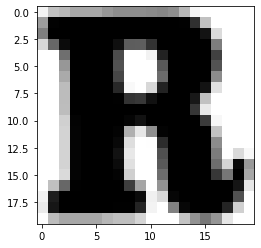

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D8FBDF0>
skel_size: (35, 35)


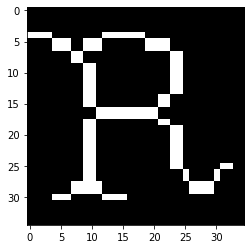

roi_size: (20, 20)


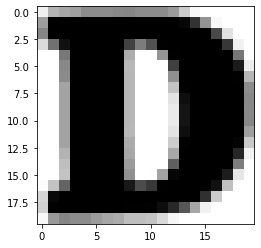

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D8FBDF0>
skel_size: (35, 35)


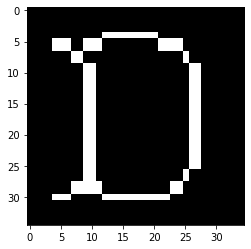

roi_size: (20, 20)


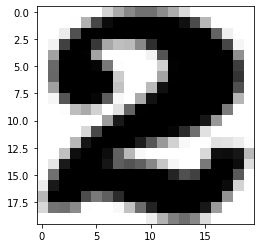

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D8FBDF0>
skel_size: (35, 35)


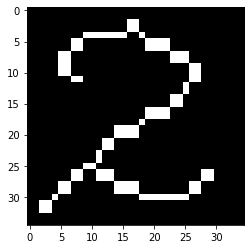

roi_size: (20, 20)


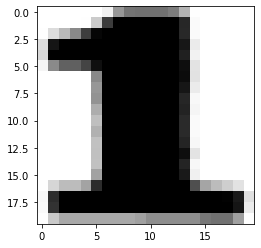

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D8FBDF0>
skel_size: (35, 35)


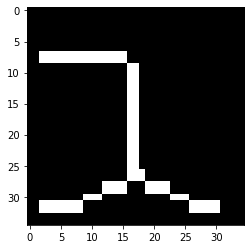

roi_size: (20, 20)


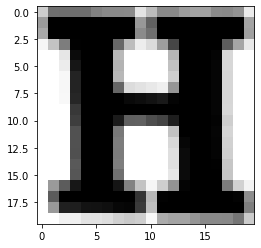

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D8FBDF0>
skel_size: (35, 35)


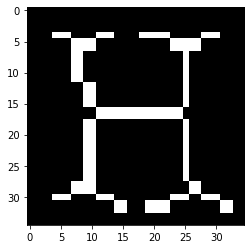

roi_size: (20, 20)


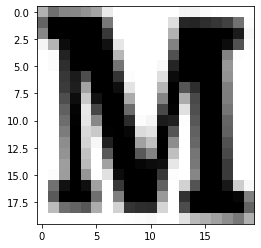

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x2379D8FBDF0>
skel_size: (35, 35)


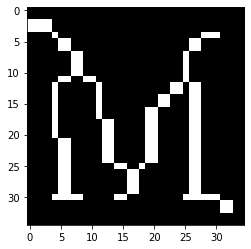

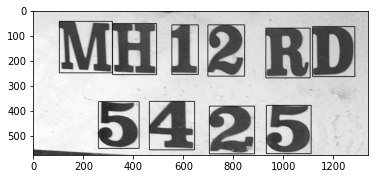

In [6]:
# create copy of image
from numpy import asarray
import sys
from skimage.exposure import histogram
from PIL import Image
im2 = gray.copy()

plate_num = ""
ROI_number = 0
# loop through contours and find letters in license plate
#retrieves only the extreme outer contours
# returns only the endpoints that are necessary for drawing the contour line`
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    
    # if height of box is not a quarter of total height then skip
    #if height / float(h) > 12: continue
    if height / float(h) > 122: continue
    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 0.5: continue
    area = h * w
    # if width is not more than 25 pixels skip
    #if width / float(w) > 15: continue
    if width / float(w) > 125: continue
    # if area is less than 100 pixels skip
    if area < 800: continue
    # draw the rectangle
   # im2 = im2.resize((35,35))
    rect = cv2.rectangle(im2, (x,y), (x+w+5, y+h+5), (0,255,0),2)
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    #roi = thresh[y:y, x:x]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi,5)
    
    roi = Image.fromarray(roi)
    roi=roi.resize((20,20),resample=3, box=None, reducing_gap=None)
    #roi.resize((50,50))
    print("roi_size:",roi.size)
    ROI_number = ROI_number + 1
    plt.imsave('extracted/skel_{}.png'.format(ROI_number), roi, cmap='gray')
    plt.imshow(roi, cmap='gray')
    plt.show()
    
    image = img_as_float(roi)
    image_binary = image < 0.5
    out_skeletonize = morphology.skeletonize(image_binary)
    out_thin = morphology.thin(image_binary)
    print(type(out_thin))
    #rows , cols = roi.shape
    #roi = roi[0:rows , 0:cols]
    #roi = roi.resize((35,35)) 
    #out_thin.resize((50,50), resample=image.NEAREST)

    #array to image
    im = Image.fromarray(out_thin)
    im=im.resize((35,35),resample=5, box=None, reducing_gap=None)
    print(im)
    print("skel_size:",im.size)
    plt.imshow(im)
    plt.show()
    plt.imsave('extracted/skel_{}.jpeg'.format(ROI_number), im, cmap='gray')
    #cv2.imwrite('extracted/skel_{}.png'.format(ROI_number),roi)
    
    #cv2.imwrite('tr_20X20/ROI_{}.png'.format(ROI_number),roi)
   # ROI_number = ROI_number + 1
#print("features")
plt.imshow(im2, cmap='gray')
plt.show()

# Normalization + sending pixels to csv

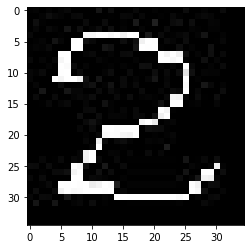

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.00784314 0.00784314 0.00784314 ... 0.         0.00392157 0.00392157]
 [0.00392157 0.03137255 0.03137255 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


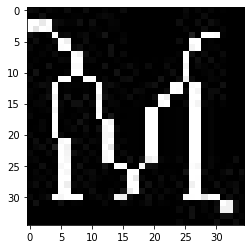

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.03921569 0.03921569 0.03921569 ... 0.04313726 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.90588236 0.90588236 0.04313726 ... 0.01568628 0.01568628 0.01568628]
 [0.         0.         0.         ... 0.02745098 0.         0.        ]
 [0.         0.9764706  0.9764706  ... 1.         1.         0.        ]]


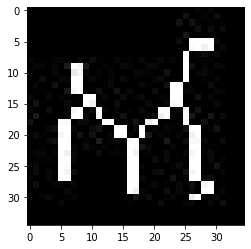

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.01176471 ... 0.00784314 0.00784314 0.00784314]
 [0.00784314 0.00784314 0.00784314 ... 0.         0.04705882 0.04705882]
 [0.04705882 0.         0.         ... 1.         1.         0.01176471]]


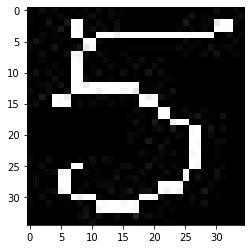

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.01568628 0.01568628 0.01568628 ... 0.01176471 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.03921569]
 [0.03921569 0.03921569 0.         ... 0.01176471 0.01176471 0.01176471]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01960784 0.01960784 0.01960784 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         1.         0.        ]]


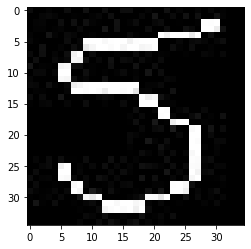

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.04313726 0.04313726 0.04313726 ... 0.05098039 0.05098039 0.05098039]
 [0.05098039 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.01960784 0.01960784 0.01960784 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         1.         0.        ]]


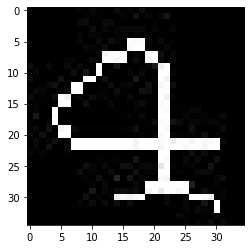

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.         0.         0.         ... 0.         0.01960784 0.01960784]
 [0.01960784 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.04313726]]


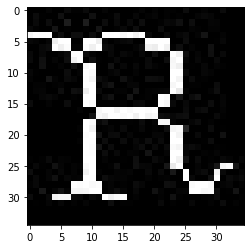

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00392157 0.00392157 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.04313726 0.04313726 0.04313726]
 ...
 [0.04313726 0.04313726 0.         ... 0.         0.         0.        ]
 [0.00784314 0.00784314 0.00784314 ... 0.99215686 0.         0.        ]
 [0.         0.04705882 0.04705882 ... 0.         0.         0.01176471]]


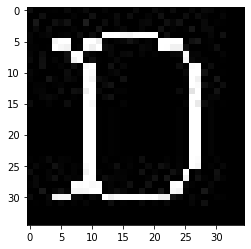

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.05098039 0.05098039 0.05098039 ... 0.         0.         0.        ]
 [0.         0.03921569 0.03921569 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.04313726 0.04313726 0.04313726]
 ...
 [0.00784314 0.00784314 0.00392157 ... 0.01568628 0.01568628 0.01568628]
 [0.         0.         0.         ... 1.         0.00392157 0.00392157]
 [0.00392157 0.         0.         ... 1.         1.         0.        ]]


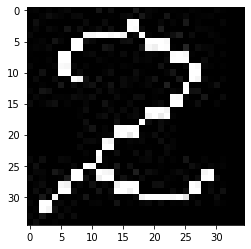

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.00784314 0.00784314 0.00784314 ... 0.         0.         0.        ]
 [0.         0.09411765 0.09411765 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         1.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]]


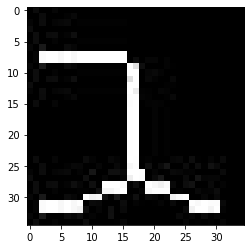

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


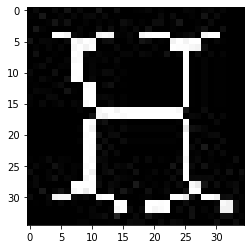

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(50, 50)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00784314 0.00784314 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00392157 0.00392157 0.00392157]
 ...
 [0.04313726 0.04313726 0.         ... 0.         0.         0.        ]
 [0.03921569 0.03921569 0.03921569 ... 0.99215686 0.         0.        ]
 [0.         0.04705882 0.04705882 ... 0.01568628 0.01568628 0.        ]]


In [7]:
import glob
pl_img = []
for img in glob.glob("C://Users/shubh/OneDrive/Desktop/dumpy/extracted/*.jpeg"):
    n= cv2.imread(img)
    pl_img.append(n)
    im2arr = np.array(n)
    plt.imshow(n, cmap='gray')
    plt.show()
    #print(im2arr)
    
#normalization start
    min = sys.maxsize
    max = -sys.maxsize
    image = n.copy()
    image.resize((50,50))
    np_image = asarray(image)
    if min > np_image.min():
        min = np_image.min()
    if max < np_image.max():
        max = np_image.max()    
        
    np_image = np_image.astype('float32')
    #print("BEGINNING PIXEL VALUES", np_image)
    print('Data Type: %s' % np_image.dtype)
    print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    np_image -= min
    np_image /= (max - min)
    print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    #np.set_printoptions(threshold=np.inf)
    #print(np_image)
    print(np_image.shape)
    print(np_image)
    '''Normalization end'''
    #sending pixels to csv
    value = np.asarray(np_image, dtype=None)
    value = value.flatten()
   # print(value)
    with open("csv/img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)
    #normalization end    

# feature extraction 

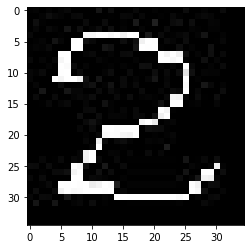

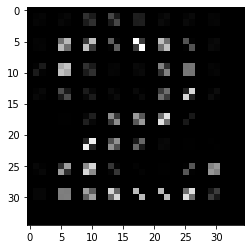

[0.0493737  0.         0.         ... 0.00425019 0.00793875 0.00385393]


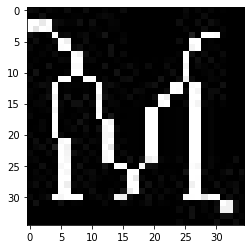

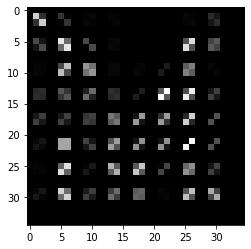

[0.00767146 0.         0.20613937 ... 0.17687743 0.31019486 0.26278017]


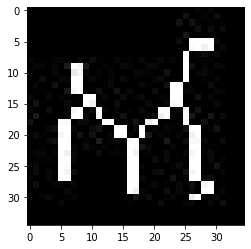

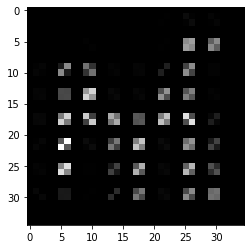

[0.         0.         0.         ... 0.00596851 0.29223944 0.13693362]


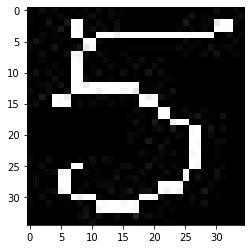

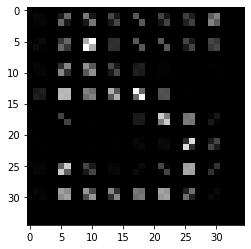

[0.07209853 0.         0.         ... 0.00415776 0.00415776 0.        ]


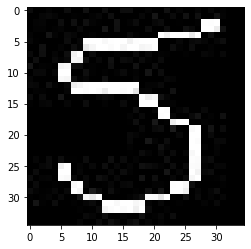

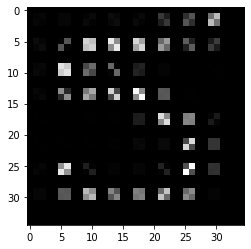

[0.06666286 0.12593807 0.07166961 ... 0.         0.0081344  0.00917413]


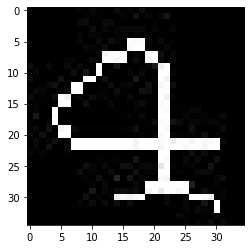

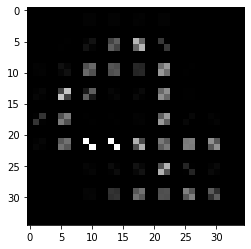

[0.         0.         0.         ... 0.31710094 0.01251221 0.00252785]


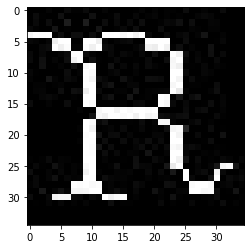

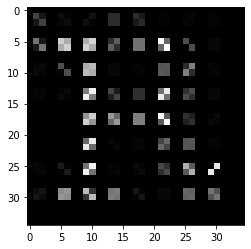

[0.01149638 0.         0.         ... 0.00718333 0.19320804 0.13266548]


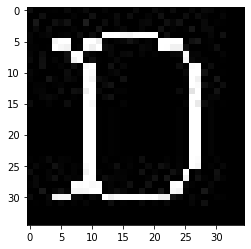

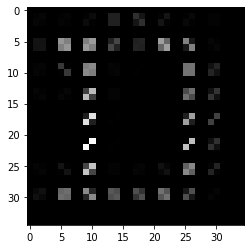

[0.02944588 0.04522928 0.03129892 ... 0.0041068  0.0041068  0.        ]


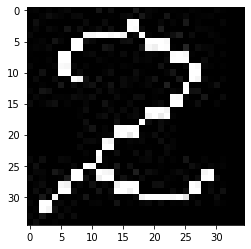

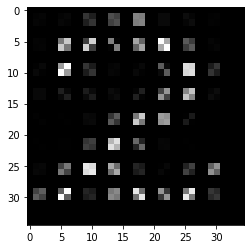

[0.04788565 0.         0.         ... 0.         0.00966141 0.16737676]


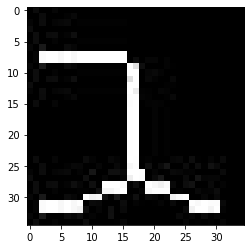

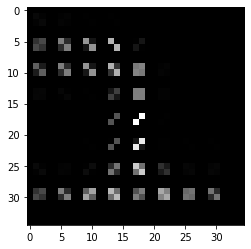

[0.05238942 0.         0.         ... 0.34412705 0.01367541 0.28069924]


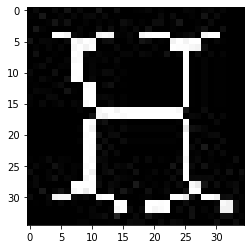

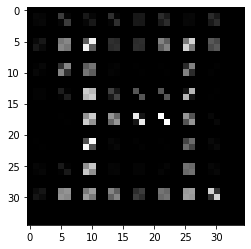

[0.07180182 0.00559875 0.         ... 0.18835494 0.28702661 0.27731918]


In [8]:
#fe ex with hog
from skimage.feature import hog
import glob
pl_img = []
for img in glob.glob("extracted/*.jpeg"):
    n= cv2.imread(img,0)
    pl_img.append(n)
    im2arr = np.array(n)
    plt.imshow(n, cmap='gray')
    plt.show()
    
    #fd, hog_image = hog(n,orientations=1,pixels_per_cell=(8,8),cells_per_block=(3,3),block_norm='L2-Hys',visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    H, hog_image = hog(n, orientations=8, pixels_per_cell=(4,4),cells_per_block=(2, 2), visualize=True, multichannel=None, feature_vector=True)
    #plt.axis("off")
    #hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 255)).astype("uint8")
    plt.imshow(hog_image, cmap="gray")
    plt.show()
    np.save('hog_features.npy',H) 
    print(H)
    with open("csv/hog_fea.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(H)


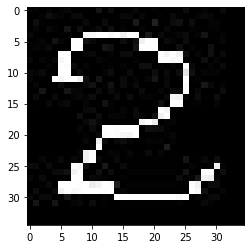

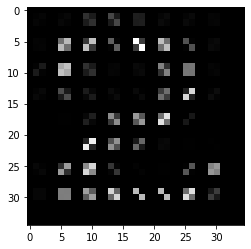

[0.0493737  0.         0.         ... 0.00425019 0.00793875 0.00385393]


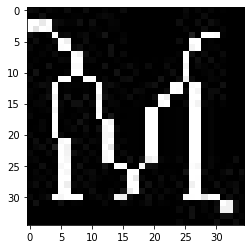

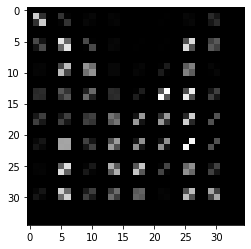

[0.00767146 0.         0.20613937 ... 0.17687743 0.31019486 0.26278017]


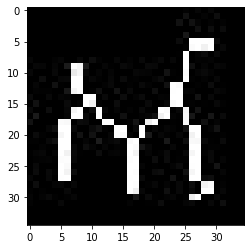

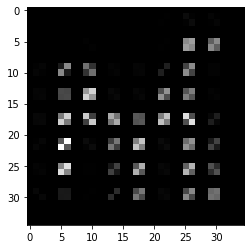

[0.         0.         0.         ... 0.00596851 0.29223944 0.13693362]


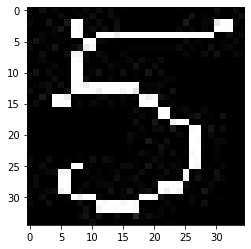

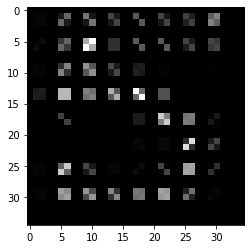

[0.07209853 0.         0.         ... 0.00415776 0.00415776 0.        ]


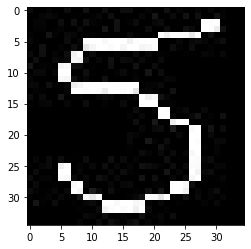

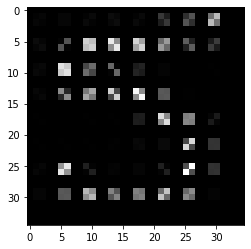

[0.06666286 0.12593807 0.07166961 ... 0.         0.0081344  0.00917413]


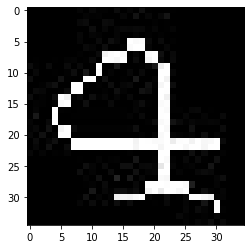

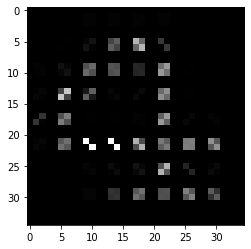

[0.         0.         0.         ... 0.31710094 0.01251221 0.00252785]


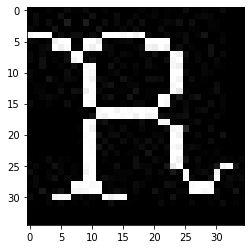

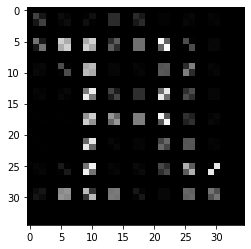

[0.01149638 0.         0.         ... 0.00718333 0.19320804 0.13266548]


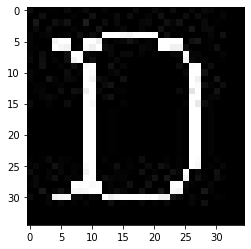

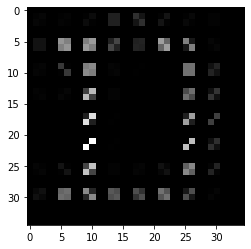

[0.02944588 0.04522928 0.03129892 ... 0.0041068  0.0041068  0.        ]


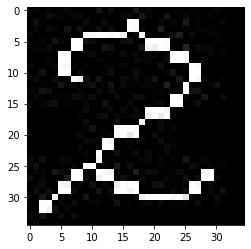

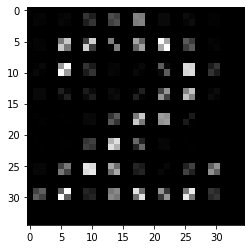

[0.04788565 0.         0.         ... 0.         0.00966141 0.16737676]


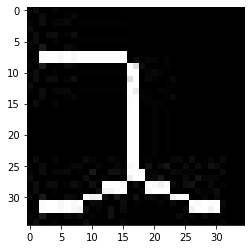

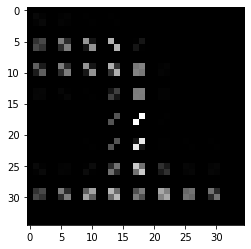

[0.05238942 0.         0.         ... 0.34412705 0.01367541 0.28069924]


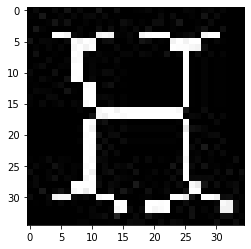

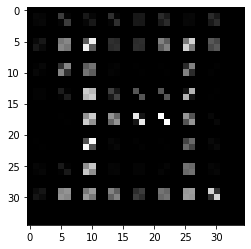

[0.07180182 0.00559875 0.         ... 0.18835494 0.28702661 0.27731918]


In [34]:
#fe ex with hog
from skimage.feature import hog
from skimage import data, color, exposure
import glob
pl_img = []
images = []
labels = []
for img in glob.glob("extracted/*.jpeg"):
    n= cv2.imread(img,0)
    pl_img.append(n)
    plt.imshow(n, cmap='gray')
    plt.show()
    
    #fd, hog_image = hog(n,orientations=1,pixels_per_cell=(8,8),cells_per_block=(3,3),block_norm='L2-Hys',visualize=False,transform_sqrt=False,feature_vector=True,multichannel=None)
    H, hog_image = hog(n, orientations=8, pixels_per_cell=(4,4),cells_per_block=(2, 2), visualize=True, multichannel=None, feature_vector=True)
    #plt.axis("off")
    hog_image = exposure.rescale_intensity(hog_image, out_range=(0, 255)).astype("uint8")
    plt.imshow(hog_image, cmap="gray")
    plt.show()
    np.save('hog_features.npy',H) 
    print(H)
    # update the data and labels
    images.append(hog_image)
    #labels.append(img)
    with open("csv/hog_fea.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(H)


In [37]:
# train Linear SVC 
from sklearn.svm import LinearSVC
from skimage import feature
print('Training on train images...')
svm_model = LinearSVC(random_state=42)
svm_model.fit(hog_image, n)

Training on train images...


ValueError: y should be a 1d array, got an array of shape (35, 35) instead.

In [10]:
import cv2
from skimage.feature import hog
import glob
hog_fea = []
for img in glob.glob("extracted/*.jpeg"):
    image = cv2.imread(img,0)
    winSize = (64,64)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 9
    derivAperture = 1
    winSigma = 4.
    histogramNormType = 0
    L2HysThreshold = 2.0000000000000001e-01
    gammaCorrection = 0
    nlevels = 64
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    #compute(img[, winStride[, padding[, locations]]]) -> descriptors
    winStride = (8,8)
    padding = (8,8)
    locations = ((10,20),)
    hist = hog.compute(image,winStride,padding,locations)
    
    print(hist)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


# Hog feature + svm classifier


<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
<class 'numpy.ndarray'>
hog 1 immagine shape
(35, 35)
ARRAY of gray matrices
11
(1, 1, 11)
(11, 1, 1)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

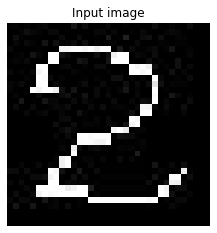

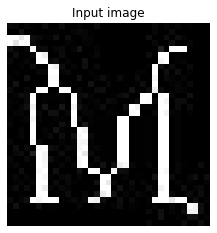

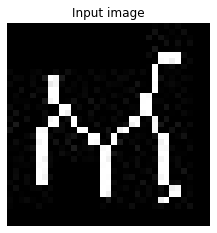

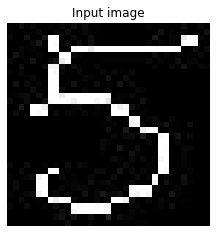

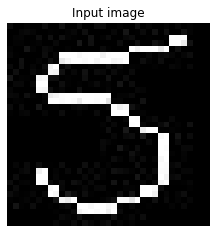

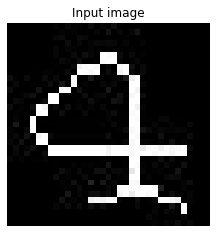

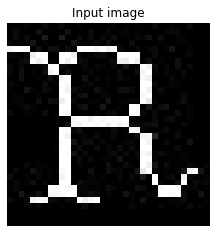

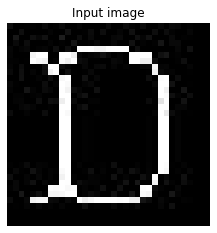

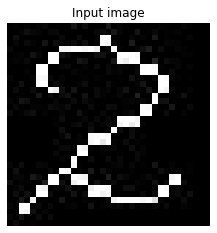

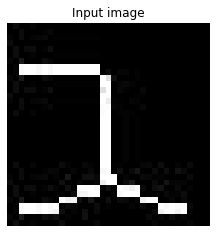

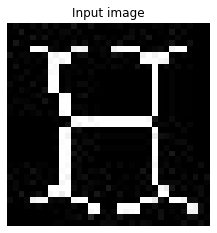

In [46]:
#try-1
#Hog Feature
from skimage import data, color, exposure
from numpy import array
# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

list_hog = []
target =[]

'''path = 'extracted/'
for infile in glob.glob(os.path.join(path, '*.jpeg') ):
    print("current file is: " + infile )
    colorato = Image.open(infile)
    greyscale = colorato.convert('1')'''
for img in glob.glob("extracted/*.jpeg"):
    n= cv2.imread(img,0)
    #fd, hog_image = hog(greyscale, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True, multichannel=None, feature_vector=True)
    H, hog_image = hog(n, orientations=8, pixels_per_cell=(4,4),cells_per_block=(2, 2), visualize=True, multichannel=None, feature_vector=True)
    plt.figure(figsize=(8, 4))
    print(type(H))
    plt.subplot(121).set_axis_off()
    plt.imshow(n, cmap=plt.cm.gray)
    plt.title('Input image')

    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
    print("hog 1 immagine shape")
    print(hog_image_rescaled.shape)

    hog_image = hog_image_rescaled.resize((200, 200))    
    list_hog.append(hog_image)
    target.append(img)

print("ARRAY of gray matrices")

print(len(list_hog))
g1 = np.dstack(list_hog)
print(g1.shape)
g1 = np.rollaxis(g1, -1)
print(g1.shape)

from sklearn import svm, metrics

n_samples = len(list_hog)
data = g1.reshape((n_samples, -1))
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=False)

clf.fit(X_train, y_train)
#classifier.fit(int(data[:n_samples/2]), int(target[:n_samples/2]))

# Now predict the value of the digit on the second half:
#expected = target[n_samples / 2:]
#predicted = classifier.predict(data[n_samples / 2:])
print("expected")

print("predicted")

In [37]:
hog_images = []
hog_features = []
for img in glob.glob("extracted/*.jpeg"):
    n= cv2.imread(img,0)
    fd,hog_image = hog(n, orientations=8, pixels_per_cell=(8,8),cells_per_block=(4, 4),block_norm= 'L2',visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

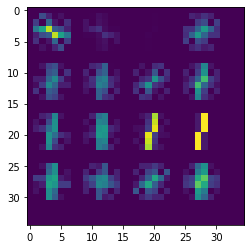

In [40]:
plt.imshow(hog_images[1])

In [41]:
labels =  np.array(dataset['labels']).reshape(len(dataset['labels']),1)

NameError: name 'dataset' is not defined

# Features area , perimter

<class 'list'>


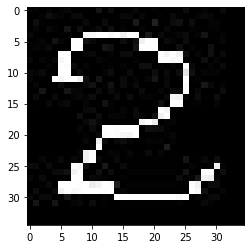

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.508385   482  385.149278           -76     0.066522  0.475345
1      0.000000     1    0.000000             1     0.785398  1.000000
2      0.000000     1    0.000000             1     0.785398  1.000000
3      0.985171     4    2.414214             1    -0.392699  0.666667
4      0.000000     1    0.000000             1     0.785398  1.000000
5      0.000000     1    0.000000             1     0.785398  1.000000
   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.508385   482  385.149278           -76     0.066522  0.475345


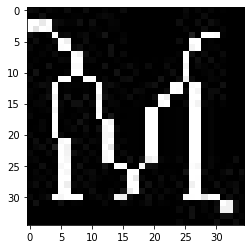

   eccentricity  area   perimeter  euler_number  orientation  solidity
0       0.56744   587  438.948268          -104     0.958010  0.517181
1       0.00000     1    0.000000             1     0.785398  1.000000
2       0.00000     1    0.000000             1     0.785398  1.000000
3       0.00000     1    0.000000             1     0.785398  1.000000
   eccentricity  area   perimeter  euler_number  orientation  solidity
0       0.56744   587  438.948268          -104      0.95801  0.517181


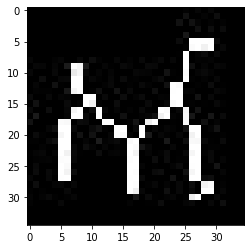

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.643992   423  327.977705           -70    -1.259220  0.475816
1      0.522233     4    1.207107             1     1.570796  0.571429
   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.643992   423  327.977705           -70     -1.25922  0.475816


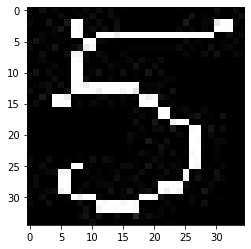

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      1.000000     3    1.000000             1     0.000000   1.00000
1      0.551037   484  386.220346           -64     0.095783   0.42794
2      0.000000     1    0.000000             1     0.785398   1.00000
3      0.000000     1    0.000000             1     0.785398   1.00000
4      0.000000     1    0.000000             1     0.785398   1.00000
5      0.000000     1    0.000000             1     0.785398   1.00000
   eccentricity  area  perimeter  euler_number  orientation  solidity
0           1.0     3        1.0             1          0.0       1.0


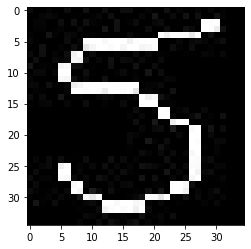

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.000000     1    0.000000             1     0.785398  1.000000
1      0.573029   484  372.090404           -75     0.171026  0.448563
2      1.000000     2    0.000000             1     1.570796  1.000000
3      0.000000     1    0.000000             1     0.785398  1.000000
4      0.000000     1    0.000000             1     0.785398  1.000000
5      0.000000     1    0.000000             1     0.785398  1.000000
6      0.000000     1    0.000000             1     0.785398  1.000000
   eccentricity  area  perimeter  euler_number  orientation  solidity
0           0.0     1        0.0             1     0.785398       1.0


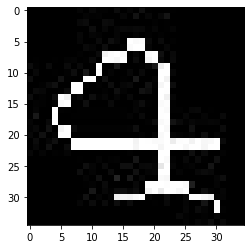

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.686516   451  368.977705           -60     0.603677  0.500555
1      0.918245     5    4.621320             1    -0.270210  0.833333
   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.686516   451  368.977705           -60     0.603677  0.500555


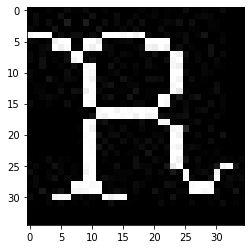

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.481061   544  406.326948           -87     0.498062  0.512724
1      0.000000     1    0.000000             1     0.785398  1.000000
2      1.000000     2    0.000000             1     0.000000  1.000000
3      1.000000     3    1.000000             1     1.570796  1.000000
4      0.932214    10   10.035534             1    -0.077533  0.526316
5      0.000000     1    0.000000             1     0.785398  1.000000
6      1.000000     2    0.000000             1     0.000000  1.000000
7      1.000000     2    0.000000             1    -0.785398  1.000000
8      0.000000     1    0.000000             1     0.785398  1.000000
   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.481061   544  406.326948           -87     0.498062  0.512724


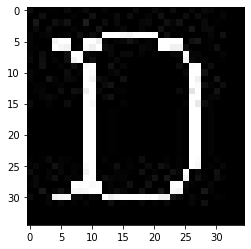

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.000000     1    0.000000             1     0.785398  1.000000
1      0.375535   456  362.492424           -49     0.071678  0.451485
2      1.000000     2    0.000000             1     0.785398  1.000000
3      0.000000     1    0.000000             1     0.785398  1.000000
4      0.000000     1    0.000000             1     0.785398  1.000000
5      0.000000     1    0.000000             1     0.785398  1.000000
6      1.000000     2    0.000000             1    -0.785398  1.000000
   eccentricity  area  perimeter  euler_number  orientation  solidity
0           0.0     1        0.0             1     0.785398       1.0


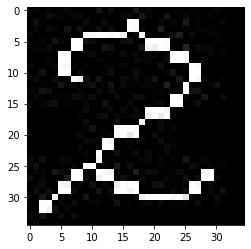

   eccentricity  area  perimeter  euler_number  orientation  solidity
0      0.502611   496  393.25588           -78    -0.185466  0.460539
1      0.000000     1    0.00000             1     0.785398  1.000000
2      0.000000     1    0.00000             1     0.785398  1.000000
3      1.000000     2    0.00000             1     0.785398  1.000000
   eccentricity  area  perimeter  euler_number  orientation  solidity
0      0.502611   496  393.25588           -78    -0.185466  0.460539


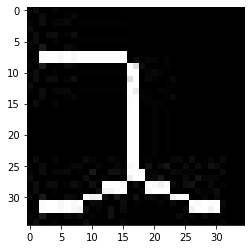

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.973723     3    1.207107             1     0.491397  0.750000
1      0.000000     1    0.000000             1     0.785398  1.000000
2      0.995143    13   11.414214             1     1.535071  0.684211
3      0.708260   345  281.338095           -32     0.611702  0.395642
4      0.973723     3    1.207107             1    -0.491397  0.750000
5      0.000000     1    0.000000             1     0.785398  1.000000
6      0.973723     3    1.207107             1     0.491397  0.750000
7      0.000000     1    0.000000             1     0.785398  1.000000
8      0.948683     4    2.414214             1    -0.785398  0.800000
9      0.000000     1    0.000000             1     0.785398  1.000000
   eccentricity  area  perimeter  euler_number  orientation  solidity
0      0.973723     3   1.207107             1     0.491397      0.75


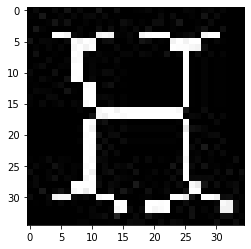

   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.537371   558  434.090404           -80     0.471148   0.48145
1      1.000000     3    1.000000             1     1.570796   1.00000
2      0.000000     1    0.000000             1     0.785398   1.00000
3      1.000000     2    0.000000             1    -0.785398   1.00000
   eccentricity  area   perimeter  euler_number  orientation  solidity
0      0.537371   558  434.090404           -80     0.471148   0.48145


In [11]:
# If your python version is not 3.x uncomment line below
#from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.measure import regionprops_table, label
import skimage.io as io
import cv2

import glob
fe_img = []
print(type(fe_img))
cnt = 0
for img in glob.glob("C://Users/shubh/OneDrive/Desktop/dumpy/extracted/*.jpeg"):
    n= cv2.imread(img,0)
    plt.imshow(n, cmap='gray')
    plt.show()

    image = np.asarray(n)
    labeled = label(image > 0)  # ensure input is binary
    data = regionprops_table(labeled,properties=('eccentricity','area', 'perimeter','euler_number','orientation','solidity'))
    #print(type(data))
    table = pd.DataFrame(data)
    #table_sorted_by_ecc = table.sort_values(by='eccentricity', ascending=False)
    # print e.g. the 10 most eccentric labels
    print(table)
    sortedtable = table.iloc[:1]
    #sortedtable.to_csv ('csv/fea_pixels.csv')
    #features = pd.DataFrame()
    print(sortedtable)
    fe_img.append(sortedtable)
    cnt = cnt + 1



In [257]:
#euler number
from skimage.measure import perimeter,centroid,entropy, euler_number, label
image = cv2.imread('extracted/skel_1.jpeg')
e4 = euler_number(image, connectivity=1)
e4

120

In [258]:
fe_img

[   eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.715429   666  546.410209           -91     0.336828  0.347962,
    eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.382754   903  759.120887          -130     1.207953  0.392779,
    eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.707413   650  526.404112           -90    -0.226364  0.339248,
    eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.620685   696  581.167568           -95    -0.264651  0.352405,
    eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.633513   718  585.125938           -80     1.070401  0.442663,
    eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.646255   769  630.866053          -129     0.521452  0.367943,
    eccentricity  area   perimeter  euler_number  orientation  solidity
 0      0.535281   796  659.487373          -129     0.133

In [203]:
file = open('csv/fea_pixels.csv', 'w+', newline ='')
 
# writing the data into the file
with file:   
    write = csv.writer(file)
    write.writerows(fe_img)

In [221]:
features = pd.DataFrame(fe_img[5], index =['2'])
#'M','5','5', '4', 'R', 'D', '2', '1', 'H'
features

,eccentricity,area,perimeter,euler_number,orientation,solidity
2,NaN,NaN,NaN,NaN,NaN,NaN


# Normalization

In [ ]:
#normalization
    min = sys.maxsize
    max = -sys.maxsize
    image = roi.copy()
   #image.resize((35,35))
    np_image = asarray(image)
    if min > np_image.min():
        min = np_image.min()
    if max < np_image.max():
        max = np_image.max()    
        
    np_image = np_image.astype('float32')
    #print("BEGINNING PIXEL VALUES", np_image)
    print('Data Type: %s' % np_image.dtype)
    print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    np_image -= min
    np_image /= (max - min)
    print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    #np.set_printoptions(threshold=np.inf)
    #print(np_image)
    print(np_image.shape)
    print(np_image)
    
    #normalization end

# sending pixels to csv


In [38]:
value = np.asarray(np_image, dtype=None)
value = value.flatten()
print(value)
with open("csv/img_pixels.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(value)

[0. 0. 0. ... 0. 0. 0.]


In [10]:
     '''# Save Greyscale values
    value = np.asarray(np_image, dtype=np.float32).reshape((np_image.size[1], np_image.size[0]))
    value = value.flatten()
    print(value)
    with open("csv/img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)'''

In [ ]:
#sending pixels to csv'''
    lst=[]
    lst=roi.tolist()
    lst

    a = np.array(lst)
    a

    value = np.asarray(a, dtype='int')
    value = value.flatten()
    print(value)
    with open("csv/img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

# random codes

In [101]:
#img = cv.imread(path)
img = out_thin.resize((50,50), refcheck=False)
normalizedImg = np.zeros((200, 200))
normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
#print(normalizedImg.shape)

plt.imshow(normalizedImg, cmap='gray')
plt.show()
#cv2.imshow('dst_rt', normalizedImg)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [21]:
import os
import os.path
rn =0
f = 'C://Users/shubh/OneDrive/Desktop/dumpy/extracted'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = cv2.imread(f_img)
    cv2.resize(img, (20,20) ,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    rn = rn +1
    cv2.imwrite('img_20X20/img2020_{}.png'.format(rn),f_img) 

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [77]:
print(out_thin)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [13]:
print(np_image.astype)

<built-in method astype of numpy.ndarray object at 0x000002BE18839150>


In [24]:
import csv
lst=[]
lst=np_image.tolist()
lst

a = np.array(lst)
a

value = np.asarray(a)
value = value.flatten()
print(value)
with open("csv/img_pixels.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(value)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
# Save Greyscale values
value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
value = value.flatten()
print(value)
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

In [ ]:
image = cv2.imread("13.jpg")
plt.imshow(image)
plt.show()
#thinned = cv2.ximgproc.thinning(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

In [ ]:

    #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/

img = img.copy() # don't clobber original
skel = img.copy()

skel[:,:] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]

        plt.imshow(skel,cmap='gray')
        plt.show()

In [37]:
import scipy.ndimage.morphology as m
import numpy as np
import cv2

def skeletonize(img):
    h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]]) 
    m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]]) 
    h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]]) 
    m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])    
    hit_list = [] 
    miss_list = []
    for k in range(4): 
        hit_list.append(np.rot90(h1, k))
        hit_list.append(np.rot90(h2, k))
        miss_list.append(np.rot90(m1, k))
        miss_list.append(np.rot90(m2, k))    
    img = img.copy()
    while True:
        last = img
        for hit, miss in zip(hit_list, miss_list): 
            hm = m.binary_hit_or_miss(img, hit, miss) 
            img = np.logical_and(img, np.logical_not(hm)) 
        if np.all(img == last):  
            break
    return img

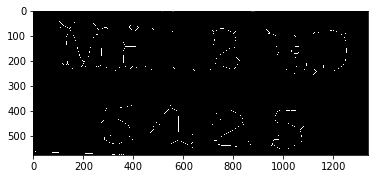

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False  True ... False False False]
 [False  True False ... False False False]
 [ True False False ... False False False]]
<class 'numpy.ndarray'>


In [50]:
img = cv2.imread("13.jpg",0)
ret,img = cv2.threshold(img,127,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
img = 255 - img
img = cv2.dilate(img, element, iterations=3)

skel = skeletonize(img)
plt.imshow(skel, cmap="gray", interpolation="nearest")
plt.show()
print(skel)
print(type(skel))